In [ ]:
!pip install wget
!pip install tensorboard
!wget https://gist.github.com/pbloem/2c3af77626d6c80f62487c35a28e3e8c/raw/5730d8f548a55a98b4415a457c5d827b33cd64d3/data_rnn.py

--2021-12-08 13:28:24--  https://gist.github.com/pbloem/2c3af77626d6c80f62487c35a28e3e8c/raw/5730d8f548a55a98b4415a457c5d827b33cd64d3/data_rnn.py
Resolving gist.github.com (gist.github.com)... 52.192.72.89
Connecting to gist.github.com (gist.github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gist.githubusercontent.com/pbloem/2c3af77626d6c80f62487c35a28e3e8c/raw/5730d8f548a55a98b4415a457c5d827b33cd64d3/data_rnn.py [following]
--2021-12-08 13:28:24--  https://gist.githubusercontent.com/pbloem/2c3af77626d6c80f62487c35a28e3e8c/raw/5730d8f548a55a98b4415a457c5d827b33cd64d3/data_rnn.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4074 (4.0K) [text/plain]
Saving to: ‘data_rnn.py.1’

data

In [ ]:
# %%
from data_rnn import load_imdb, load_ndfa, load_brackets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import sklearn.model_selection
import torch
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [ ]:
dataset = "brackets"

if dataset == "ndfa":
    x_train, (i2w, w2i) = load_ndfa(n=150_000)

elif dataset == "brackets":
    x_train, (i2w, w2i) = load_brackets(n=150_000)

Lets create a function to decode a sequence, and print a random decoded sample from the training set

In [ ]:
def decode(sample):
    return(" ".join([i2w[i] for i in sample]))
print(decode(random.choice(x_train)))

( )


Lets get the index of important tokens


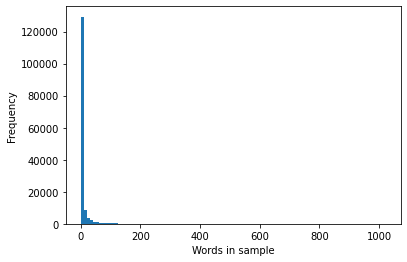

In [ ]:
pad_index = i2w.index(".pad")
start_index = i2w.index(".start")
end_index = i2w.index(".end")

# Hist of sample length distribution
plt.hist([len(sample) for sample in x_train], bins=100)
plt.xlabel("Words in sample")
plt.ylabel("Frequency")
plt.show()

Lets split the training data into train and validation

In [ ]:
 # 140k train samples, 10k val
 x_train, x_val, = sklearn.model_selection.train_test_split(x_train, test_size = (1/15))

Lets create a function to create the labels (y)

Function which truncates or pads samples to standard size, 

NOTE: Batch size now actually refers to setence_length * sentences, instead of just sentences.

In [ ]:
# Function which truncates or pads samples to standard size
# Batch size now actually refers to setence_length * sentences, instead of just sentences.
def pad_and_truncate_static_total_size(x, batch_size, pad_index, start_index, end_index):
    m = len(x)
    y = x.copy()
    # Sorted x and y using len of x
    # Because we sort, more similairly sized samples are together, thus less padding, thus smaller dataset.
    sorted_x = [x for (x,y) in sorted(zip(x, y), key = lambda pair: len(pair[0]))]
    sorted_y = [y for (x,y) in sorted(zip(x, y), key = lambda pair: len(pair[0]))]
    
    x_batches, y_batches = [], []
    x_batch_current, y_batch_current = [], []
    current_batch_size = 0
    for x, y in zip(sorted_x, sorted_y):
        x_batch_current.append(x)
        y_batch_current.append(y)
        # +2 because we want to add .start and .end to the sentence too
        current_batch_size += len(x) + 2

        # If we have reached batch_size, create actual batch
        if current_batch_size > batch_size:
            # Longest sample occuring in batch
            max_batch_size = len(max(x_batch_current, key = lambda x: len(x)))
            
            # Create padded batchec
            x_batch = [sample + [pad_index]*(max_batch_size-len(sample)) for sample in x_batch_current]
            x_batch = [[start_index] + sample + [end_index] for sample in x_batch]
            
            y_batch = [sample + [pad_index]*(max_batch_size-len(sample)) for sample in y_batch_current]
            y_batch = [sample + [end_index] + [0] for sample in y_batch]

            x_batches.append(torch.tensor(x_batch, dtype=torch.long))
            y_batches.append(torch.tensor(y_batch, dtype=torch.long))

            # Reset current_batch
            x_batch_current, y_batch_current = [], []
            current_batch_size = 0

    # Shuffle the batches to counter catastrophic forgetting.
    x_and_y = list(zip(x_batches, y_batches))
    random.shuffle(x_and_y)
    x_batches, y_batches = zip(*x_and_y)

    return x_batches, y_batches

In [ ]:
batch_size = 5000
x_train_padded, y_train_padded = pad_and_truncate_static_total_size(x_train, batch_size, pad_index, start_index, end_index)
print(f"Number of batches: {len(x_train_padded)}")

print(decode(x_train_padded[0][0].tolist()))
print(decode(y_train_padded[0][0].tolist()))

Number of batches: 305
.start ( ) .end
( ) .end .pad


We finished all the pre-processing, lets create the actual model now.

In [ ]:
class AutoregLSTM(nn.Module):
    """ElmanNet implemented using the LSTM layer of pytorch"""
    def __init__(self, num_LSTM_layers = 1 ):
        super().__init__()

        self.name = "AutoregLSTM"
        self.num_LSTM_layers = num_LSTM_layers
       
        self.embedding = nn.Embedding(len(i2w), 32)
        self.rnn= nn.LSTM(32, 16, num_layers=self.num_LSTM_layers, batch_first=True)
        # The last layer always need to have output size of vocab
        self.linear_final = nn.Linear(16, len(i2w))
        

    def forward(self, x):
        x = self.embedding(x)
        x, hidden = self.rnn(x)
        x = self.linear_final(x)
        return x

Run tensorboard to see stats during training

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 142), started 0:20:35 ago. (Use '!kill 142' to kill it.)

<IPython.core.display.Javascript object>

Function to sample from model prediction, is from the assignment

In [ ]:
import torch.distributions as dist

def sample(lnprobs, temperature=1.0):
    """
    Sample an element from a categorical distribution
    :param lnprobs: Outcome logits
    :param temperature: Sampling temperature. 1.0 follows the given
    distribution, 0.0 returns the maximum probability element.
    :return: The index of the sampled element.
    """
    if temperature == 0.0:
        return lnprobs.argmax()
    p = F.softmax(lnprobs / temperature, dim=0)
    cd = dist.Categorical(p)
    return cd.sample()

  Lets create function to check if the predictions for our given datasets are correct

In [ ]:
def sample_is_correct_brackets(sample):
    return (sample.count(w2i['(']) - sample.count(w2i[')'])) == 0
  
def sample_is_correct_NDFA(sample):
    legal_transitions = {
     "s":      ["s", ".end", "a", "k", "u"],
     ".start": ["s"],
     "a" : ["b"],
     "b": ["c"],
     "c": ["!"],
     "!": ["s", "a", "k", "u"],
     "k": ["l"],
     "l": ["m"],
     "m": ["!"],
     "u": ["v"],
     "v": ["w"],
     "w": ["!"] }

    for i in range(len(sample)):
        current_char = i2w[sample[i]]
        if not i == (len(sample) - 1):
          next_char = i2w[sample[i+1]]
          if next_char not in legal_transitions[current_char]:
            return False
    return True

Now the training loop


In [ ]:
def test_network(network):
    epochs = 100
    gpu_mode = True
    net = network()

    if gpu_mode:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
        device = "cpu"
        
    # print(f"Testing {net.__class__.__name__}, learning rate = {learning_rate}")

    weights = np.ones(len(i2w))
    weights[pad_index] = 0
    weights = torch.tensor(weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight = weights, reduction='sum')

    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

    if gpu_mode:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
        device = "cpu"
    print(f"Model is running on {device}")
    net.to(device)
    t0 = time.time()
    loss_list = []
    batch_i = 0
    for epoch in range(epochs):  # loop over the dataset multiple times

        # Shuffle the batches to counter catastrophic forgetting.
        x_and_y = list(zip(x_train_padded, y_train_padded))
        random.shuffle(x_and_y)
        x_shuffled, y_shuffled = zip(*x_and_y)

        running_loss = 0.0
        for i, (x_data, y_data) in enumerate(zip(x_shuffled, y_shuffled)):
            batch_i += 1
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = x_data.to(device), y_data.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            # dimension fix here
            labels = torch.flatten(labels).to(device)
            outputs=torch.flatten(outputs, start_dim=0, end_dim=1).to(device)

            loss = criterion(outputs, labels)/outputs.shape[0]
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
                loss_list.append(running_loss / 100)
                running_loss = 0.0
                writer.add_scalar("Training loss", loss_list[-1], batch_i)
            
            # Get gradient norms
            total_norm = 0
            for p in net.parameters():
              param_norm = p.grad.detach().data.norm(2)
              total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            writer.add_scalar("Total gradient norm (l2)", total_norm, batch_i)

        ####### Calculate validation accuracy
        # since we're not training, we don't need to calculate the gradients for our outputs

        # Starting states of our samples, from which to predict from
        if dataset == "ndfa":
            seed = [w2i['.start'], w2i['s']]
        if dataset == "brackets":
            seed = [w2i['.start'], w2i['('], w2i['('], w2i[')']]

        with torch.no_grad():
            print(f"Epoch {epoch}")
            total_correct = 0
            
            # Create 100 samples, and check how much are correct
            for i in range(100):
                x = torch.tensor([seed], dtype=torch.long).to(device)

                while x.shape[1] < 100 and x[0,-1] != w2i[".end"]:
                    output = net(x)
                    prediction_logits = output[0,-1,:]
                    prediction = torch.tensor([[sample(prediction_logits, temperature=1.0)]]).to(device)
                    x = torch.cat([x, prediction], dim=1).to(device)
                # Only print first 5 for each epoch
                if i < 5:
                  print(decode(x[0]))

                if dataset == "ndfa":
                    correct = sample_is_correct_NDFA(x[0].tolist())
                if dataset == "brackets":
                    correct = sample_is_correct_brackets(x[0].tolist())

                total_correct += int(correct)

            print(f"Samples correct: {total_correct}")
            writer.add_scalar("Samples correct", total_correct, epoch)
                
    t1 = time.time()
    print(f"Total time taken: {t1 - t0}")

    print('Finished Training')
    return loss_list

loss_list = test_network(AutoregLSTM)
writer.flush()

Model is running on cuda:0
[1,   100] loss: 1.024
[1,   200] loss: 0.778
[1,   300] loss: 0.720
Epoch 0
.start ( ( ) ( ( ) ) ) .end
.start ( ( ) ( ( ) .end
.start ( ( ) ( ) ( .pad .end
.start ( ( ) ) ( ( ) ) ( ) ) ( ) ) ( ( ( ( ) ( ) ) ( ) ( ) ( ) ) .end
.start ( ( ) ( ( ) ( ) ( ( ( ( ) ) ( ) ) .end
Samples correct: 31
[2,   100] loss: 0.632
[2,   200] loss: 0.580
[2,   300] loss: 0.570
Epoch 1
.start ( ( ) ) .end
.start ( ( ) ( ( ( ( ) ) ) ( ( ( ) ) ( ) ) ) ( ) ( ( ( ) ) ) ) ( ( ( ( ( ( ) ( ) ) ( ) ( ) ( ( ) ) ) ) ( ) ) .end
.start ( ( ) ) .end
.start ( ( ) ) .end
.start ( ( ) .end
Samples correct: 52
[3,   100] loss: 0.532
[3,   200] loss: 0.533
[3,   300] loss: 0.531
Epoch 2
.start ( ( ) ) ) .end
.start ( ( ) ) .end
.start ( ( ) ( ) ) .end
.start ( ( ) .end
.start ( ( ) ( ( ( ) ( ( ( ( ( ( ) ( ( ( ( ) ( ) ( ( ) ( ) ( ) ( ) ) ) ( ) ( ( ( ( ) ( ) ) ( ( ) ) ) ( ) ) ( ( ( ) ) ) ) ) ) ) ( ) ) ( ) ( ( ( ( ( ( ( ( ) ) ) ( ( ( ( ) ) ( ) ( ) ) ) ) ) ( ) ( ) ) ) ) ( (
Samples correct: 77
[4, 